In [236]:
import pandas as pd
import numpy as np
import shapely
import matplotlib.pyplot as plt
import geopandas as gpd
import glob
import os
import seaborn as sns
import copy

# Acquire paths and cellid
paths = glob.glob('../data/Chosen_grids_data/*.csv')
cellId = [os.path.splitext(os.path.basename(path))[0] for path in paths]

In [297]:
cellId

['3215', '5111', '5202', '2972', '5550']

In [237]:
class CellData:
    # Class to manipulate data
    def __init__(self, cellId, dfs):
        pass

In [238]:
df1 = pd.read_csv(paths[0], parse_dates=['date'])

In [239]:
df1 = df1.drop(['air_quality'], axis=1)

In [240]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 6 columns):
date                720 non-null datetime64[ns]
hour                720 non-null int64
current             720 non-null float64
precipitation       652 non-null float64
temperature         720 non-null float64
temperature_diff    720 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 33.8 KB


In [242]:
dfs = [pd.read_csv(path,parse_dates=['date']).drop(['air_quality'], axis=1) for path in paths]

In [248]:
for df in dfs:
    df.fillna(value=0, inplace=True)
    df['dayofweek'] = df['date'].dt.dayofweek

In [250]:
dfs[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 7 columns):
date                720 non-null datetime64[ns]
hour                720 non-null int64
current             720 non-null float64
precipitation       720 non-null float64
temperature         720 non-null float64
temperature_diff    720 non-null float64
dayofweek           720 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 39.5 KB


In [252]:
dfs[0].head()

,date,hour,current,precipitation,temperature,temperature_diff,dayofweek
0,2013-11-01,0,70.749732,0.0,9.6,4.4,4
1,2013-11-01,1,73.326613,0.0,9.6,4.4,4
2,2013-11-01,2,71.580059,0.0,9.6,4.4,4
3,2013-11-01,3,70.577939,0.0,9.6,4.4,4
4,2013-11-01,4,67.170729,0.0,9.6,4.4,4


In [256]:
# Correlation heatmap

def correlation_heatmap(dfs, label):
    values = np.array([df[label].values for df in dfs]).T
    df = pd.DataFrame(values)
    
    corr = df.corr()
    sns.heatmap(corr,
            annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
    plt.title(label)
    plt.show()

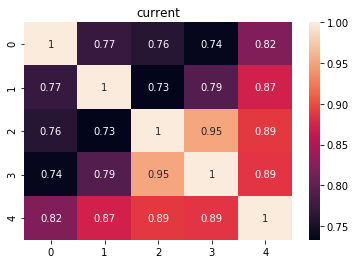

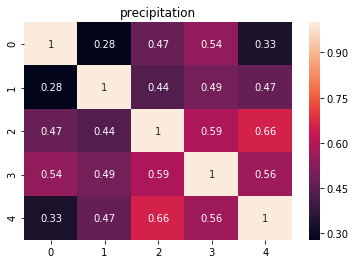

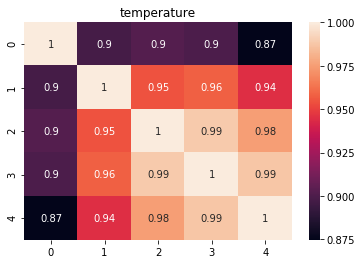

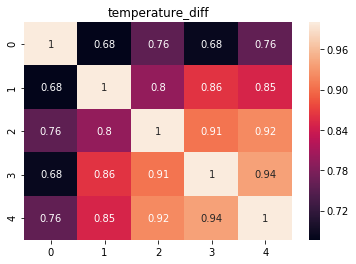

In [257]:
columns = ['current','precipitation','temperature','temperature_diff']

for col in columns:
    correlation_heatmap(dfs, col)

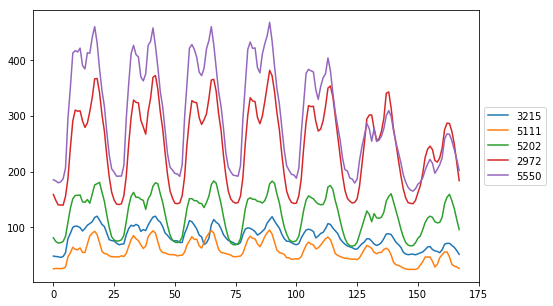

In [360]:
# Average adjust
dfs_avg_adjusted = copy.deepcopy(dfs)
avgs = []

plt.figure(figsize=(10,5))

for i, df in enumerate(dfs_avg_adjusted):
    
    vals = df.groupby(['dayofweek','hour'])['current'].mean().values
    
    hour_nums = 24
    # Calculated residuals
    df['current'] = df.apply(lambda row: row['current'] - 
                             vals[int(row['dayofweek']*hour_nums + row['hour'])], axis=1)
    
    # Store the averages
    df['avg_current'] = df.apply(lambda row:
                             vals[int(row['dayofweek']*hour_nums + row['hour'])], axis=1)
    
    
    thrs = df.groupby(['dayofweek','hour'])['current'].quantile(.75).values

    df['threshold'] = df.apply(lambda row:
                             thrs[int(row['dayofweek']*hour_nums + row['hour'])], axis=1)
    
    # Classify if on high peak
    df['current_class'] = df.apply(lambda row: 
                                  0 if row['current'] <= row['threshold'] else 1, axis=1)
    
    avgs.append(vals)
    plt.plot(vals,label=cellId[i])
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [355]:
# Adjusted order
columns = ['date','dayofweek','hour','current','avg_current','threshold','current_class',
           'temperature','temperature_diff','precipitation']

In [356]:
new_dfs = [df[columns] for df in dfs_avg_adjusted]

In [358]:
# Exporte data

for id_, df in zip(cellId, new_dfs):
    df.to_csv('../data/Chosen_grids_data_add_class/{}.csv'.format(id_), index=None)

In [265]:
def self_correlation_heatmap(df):
    corr = df.corr()
    sns.heatmap(corr,
            annot=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

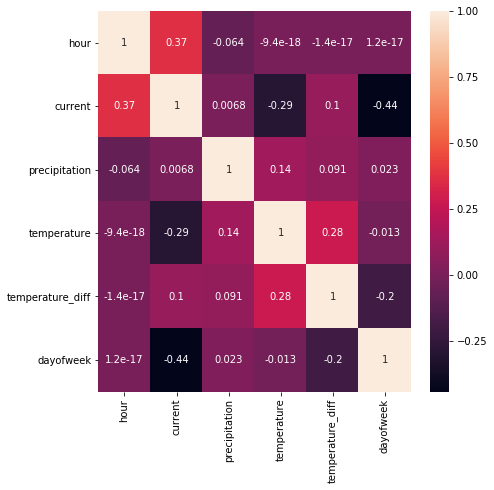

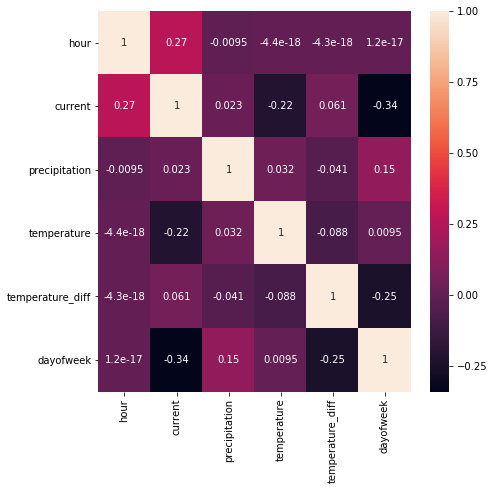

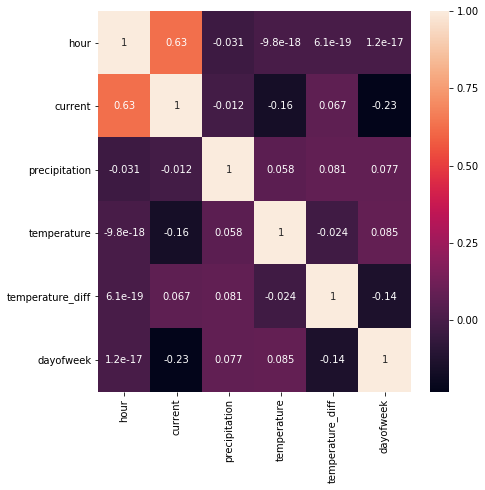

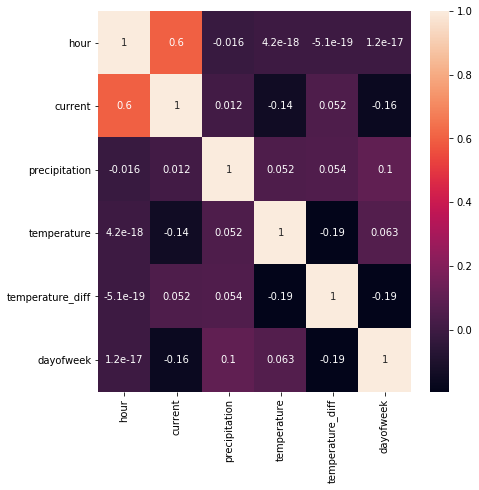

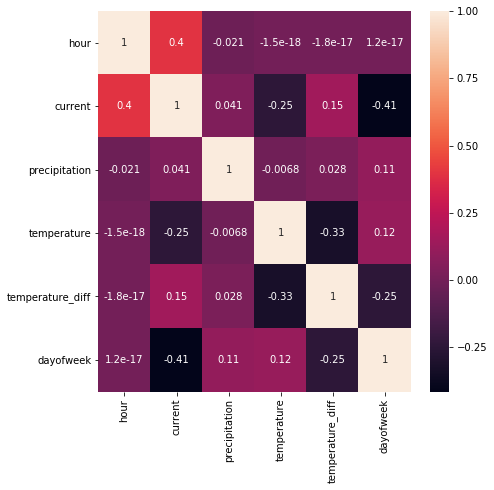

In [267]:
for df in dfs:
    plt.figure(figsize=(7,7))
    self_correlation_heatmap(df.iloc[:,1:])
    plt.show()

In [284]:
### Basic linear regression using 4 location current to predict the current in the 5 location
from sklearn import linear_model
from sklearn.model_selection import train_test_split

lr = linear_model.LinearRegression()

X = current.T[:,:4]
y = current.T[:,4]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=15)

lr.fit(X_train, y_train)
# lr.score(X_test,y_test)
results = lr.predict(X_test)    
print(np.sqrt(np.mean(np.square([t - r for t, r in zip(results,y_test)]))))

32.49060387528039


In [285]:
lr.coef_

array([ 0.76873024,  1.81231031,  1.42523065, -0.07217174])

In [295]:
### Basic linear regression using the parameters to estimate the current

def basic_reg1(df):
    
    lr = linear_model.LinearRegression()
    X = df.iloc[:,3:-1].values # Using precipitation, temperature and temperature_diff
    
    y = df.iloc[:,2].values  # avg adjusted current
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=15)

    lr.fit(X_train, y_train)
    results = lr.predict(X_test)
    
    print(np.sqrt(np.mean(np.square([t - r for t, r in zip(results,y_test)]))))
    print(lr.score(X_test,y_test))
    return lr

# for df in dfs_avg_adjusted:
#     basic_reg1(df)

10.087589686629475
0.31080473019122046
8.260833551206543
0.10451331909930262
7.296733800423476
0.2585764512575859
14.15825694316914
0.27471167341578007
25.89632608593649
0.24594688494765915


In [296]:
### Basic linear regression using the parameters to estimate the current

from sklearn.preprocessing import OneHotEncoder

def basic_reg2(df):
    
    lr = linear_model.LinearRegression()
    enc = OneHotEncoder()
    time_features = enc.fit_transform(df.iloc[:,[1,-1]].values).toarray()
    
    # Using ont-hot-coding hour, precipitation, temperature and temperature_diff
    X = np.hstack((time_features, df.iloc[:,3:-1].values)) 
    y = df.iloc[:,2].values  # avg adjusted current
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=15)

    lr.fit(X_train, y_train)
    results = lr.predict(X_test)

    print(np.sqrt(np.mean(np.square([t - r for t, r in zip(results,y_test)]))))
    print(lr.score(X_test,y_test))
    return lr

# for df in dfs:
#     basic_reg2(df)

13.47670054833483
0.6180434968069541
10.15315903249167
0.7394066789993673
9.934299405612057
0.9237326463465448
19.907184213105538
0.930654810155972
41.605372908077484
0.8219745957177245


In [361]:

clf = BayesianRidge()

clf.fit(current[:,:-1], current[:,-1])

mean = clf.predict(current[0,].reshape(1,-1))